In [7]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Conv2D

In [9]:
import numpy as np
import pandas as pd
import os

In [10]:
# # !pip install tensorflow numpy pandas matplotlib seaborn opencv-python tqdm scikit-learn --quiet
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.applications import preprocess_input
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2


In [12]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using GPU
Num GPUs Available:  2


In [13]:

disease_types = ['Bacterial Leaf Disease','Fungal Brown Spot Disease','Dried Leaf','Healthy Leaf']
# disease_types = ['Bacterial Leaf Disease','Fungal Brown Spot Disease']

# data_dir = '/content/drive/MyDrive/Betal Leaf_Project/temp_Images'
data_dir = '/kaggle/input/betel-dataset/resized_clahe'
train_dir = os.path.join(data_dir)
# test_dir = os.path.join(data_dir, 'test')

In [14]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(3)

,File,DiseaseID,Disease Type
0,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
1,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
2,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease


In [15]:
len(train_data)

1000

In [16]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Dried Leaf/Dried_Leaf(94).jpg,2,Dried Leaf
1,Dried Leaf/Dried_Leaf(151).jpg,2,Dried Leaf
2,Dried Leaf/Dried_Leaf(2).jpg,2,Dried Leaf
3,Dried Leaf/Dried_Leaf(149).jpg,2,Dried Leaf
4,Fungal Brown Spot Disease/Fungal_Brown_Spot_Di...,1,Fungal Brown Spot Disease


In [17]:

IMAGE_SIZE = 224
SEED = 42

# def read_image(filepath):
    
#     # Step 1: Load the image
#     image = cv2.imread(os.path.join(data_dir, filepath))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Step 2: Resize the image
#     image_resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

#     # Step 3: Normalize the image to the range [-1, 1]
#     image_normalized = (image_resized / 127.5) - 1.0

#     return image_normalized

#     return focused_image


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

In [18]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = image

1000it [00:02, 390.73it/s]


In [19]:


X_train = X_train / 255.0
print('Train Shape: {}'.format(X_train.shape))
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=4)

Train Shape: (1000, 224, 224, 3)


In [20]:
# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=SEED)

In [21]:
len(X_train)

700

In [22]:
EPOCHS = 50
SIZE=224
N_ch=3

# Densenet

In [23]:
def se_block(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Multiply()([input_tensor, se])
    return se

# Custom CNN with Attention
def build_attention_cnn(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Convolutional Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = se_block(x)  # Add SE block for channel attention
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(0.2)(x)

    # Convolutional Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(0.3)(x)

    # Convolutional Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(0.4)(x)
    # Convolutional Block 4
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(0.3)(x)
    

    # Flatten the output
    x = layers.Flatten()(x)

    # Fully Connected Block
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Define the Model
    model = models.Model(inputs, outputs)

    # Compile the Model
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Instantiate the model
input_shape = (224, 224, 3)
num_classes = 4
model = build_attention_cnn(input_shape=input_shape, num_classes=num_classes)

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization[0… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            260 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ multiply[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 112, 112, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 128)      │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1, 8)        │          1,032 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 1, 128)      │          1,152 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)

 Total params: 7,415,344 (28.29 MB)

 Trainable params: 7,413,552 (28.28 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, verbose=5, min_lr=1e-3)
checkpoint = ModelCheckpoint('/kaggle/working//Custom_CNN_224_250[att].keras', monitor='val_accuracy', save_best_only=True)


In [25]:
import tensorflow as tf

tf.keras.backend.clear_session()
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size).repeat().prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size).repeat().prefetch(1)

# Calculate steps per epoch
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Train the model
EPOCHS = 50
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[early_stopping, annealer, checkpoint],
    validation_data=val_dataset,
    validation_steps=validation_steps,
    shuffle=True
)

Epoch 1/50
43/43 - 31s - 718ms/step - accuracy: 0.6206 - loss: 5.4196 - val_accuracy: 0.3125 - val_loss: 9.1572 - learning_rate: 0.0010
Epoch 2/50
43/43 - 21s - 481ms/step - accuracy: 0.7412 - loss: 4.9450 - val_accuracy: 0.2394 - val_loss: 9.4064 - learning_rate: 0.0010
Epoch 3/50
43/43 - 4s - 97ms/step - accuracy: 0.8085 - loss: 4.0874 - val_accuracy: 0.2465 - val_loss: 7.4870 - learning_rate: 0.0010
Epoch 4/50
43/43 - 4s - 96ms/step - accuracy: 0.8392 - loss: 3.4232 - val_accuracy: 0.2324 - val_loss: 6.7918 - learning_rate: 0.0010
Epoch 5/50
43/43 - 5s - 107ms/step - accuracy: 0.8421 - loss: 2.9197 - val_accuracy: 0.4859 - val_loss: 4.8187 - learning_rate: 0.0010
Epoch 6/50
43/43 - 4s - 94ms/step - accuracy: 0.8743 - loss: 2.5204 - val_accuracy: 0.4824 - val_loss: 4.4487 - learning_rate: 0.0010
Epoch 7/50
43/43 - 4s - 91ms/step - accuracy: 0.8640 - loss: 2.2679 - val_accuracy: 0.4613 - val_loss: 5.2328 - learning_rate: 0.0010
Epoch 8/50
43/43 - 4s - 102ms/step - accuracy: 0.8655 - l

In [26]:
# model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.8697 - loss: 1.3588
Final Loss: 1.3359297513961792, Final Accuracy: 0.8733333349227905


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


Text(0.5, 192.72222222222217, 'Predicted')

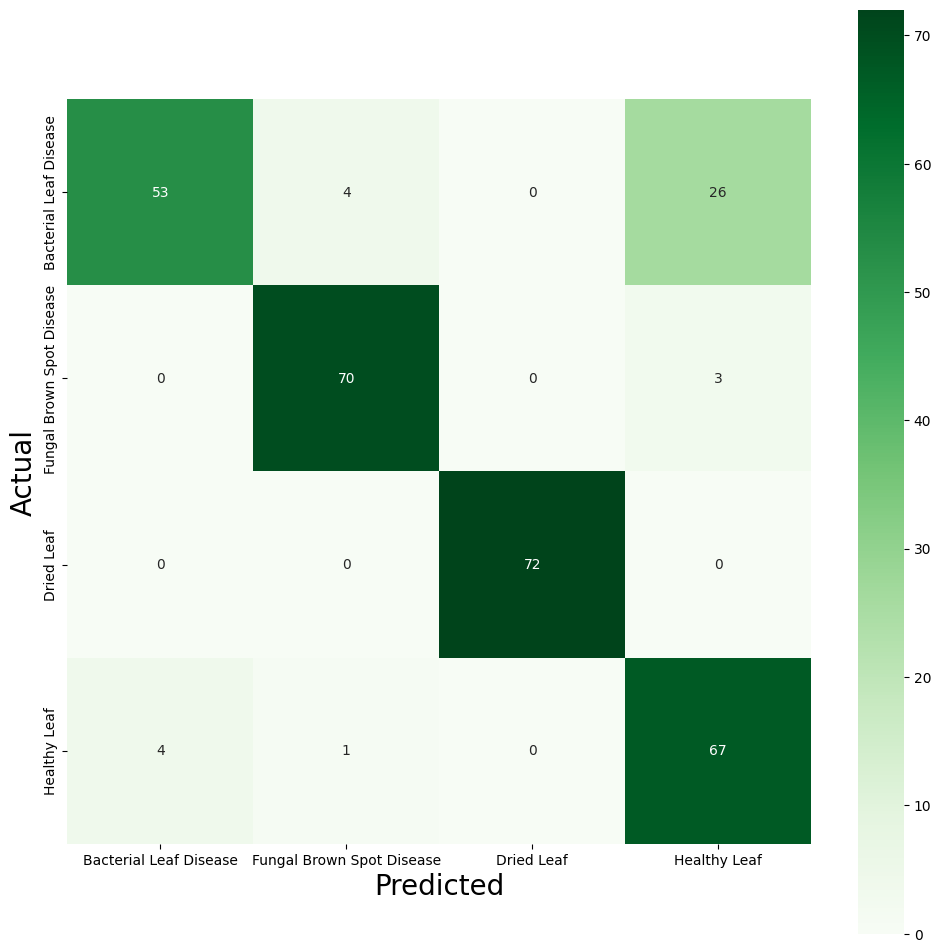

In [27]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(Y_true, Y_pred, target_names=disease_types)
print(report)

                           precision    recall  f1-score   support

   Bacterial Leaf Disease       0.93      0.64      0.76        83
Fungal Brown Spot Disease       0.93      0.96      0.95        73
               Dried Leaf       1.00      1.00      1.00        72
             Healthy Leaf       0.70      0.93      0.80        72

                 accuracy                           0.87       300
                macro avg       0.89      0.88      0.88       300
             weighted avg       0.89      0.87      0.87       300



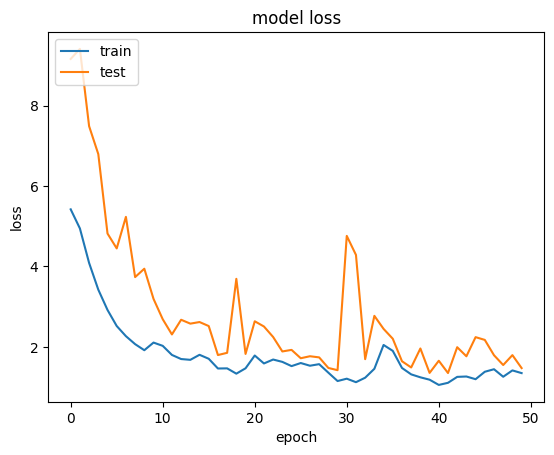

In [29]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

GRAD CAMM****

In [30]:
for layers in model.layers:
    print(layers.name)

input_layer
conv2d
batch_normalization
global_average_pooling2d
reshape
dense
dense_1
multiply
max_pooling2d
dropout
conv2d_1
batch_normalization_1
global_average_pooling2d_1
reshape_1
dense_2
dense_3
multiply_1
max_pooling2d_1
dropout_1
conv2d_2
batch_normalization_2
global_average_pooling2d_2
reshape_2
dense_4
dense_5
multiply_2
max_pooling2d_2
dropout_2
conv2d_3
batch_normalization_3
global_average_pooling2d_3
reshape_3
dense_6
dense_7
multiply_3
max_pooling2d_3
dropout_3
flatten
dense_8
batch_normalization_4
dropout_4
dense_9
batch_normalization_5
dropout_5
dense_10


In [37]:
model1 = model

In [38]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers, models

from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model # Import load_model here
from tensorflow.keras.preprocessing import image
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

label_name = ['Bacterial Leaf Disease','Fungal Brown Spot Disease','Dried Leaf','Healthy Leaf']


img_path = '/kaggle/input/betel-dataset/Resized 224_250/Bacterial Leaf Disease/Bacterial_Leaf_Spot_Disease(86).jpg'
# img_path = '/content/110608-01-8356c-lg.jpg'

last_conv_layer_name = "conv2d_3"  # Ensure this matches your model's last conv layer
img_size = (224, 224)

# Preprocessing function
def preprocess_input(img_array):
    return img_array / 255.0

# Load the custom model

# Function to load and preprocess the image
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    # Add a batch dimension
    return np.expand_dims(array, axis=0)

# Grad-CAM heatmap generation


def grad_cam_plus(model, img, layer_name="global_average_pooling2d", label_name=None, category_id=None):
    """Get a heatmap by Grad-CAM++."""
    # Do not expand dimensions here, as the input should already have a batch dimension
    img_tensor = img

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name is not None:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num / alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0, 1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights * alphas, axis=(0, 1))
    grad_cam_map = np.sum(deep_linearization_weights * conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

# model1 = load_model("/content/drive/MyDrive/Betal Leaf_Project/Fresh Start/checkpoint/vgg16[clahe].keras")
# # model2 = load_model("/content/drive/MyDrive/Betal Leaf_Project/Fresh Start/Models/Checkpoints/vgg16_[edge].keras")
# # model3 = load_model("/content/drive/MyDrive/Betal Leaf_Project/Fresh Start/Models/Checkpoints/Best_densenet.keras")



img_array = get_img_array(img_path, size=img_size)  # This already has the batch dimension
img_array = preprocess_input(img_array)  # Normalize the image

# Predict the class of the image
preds1 = model1.predict(img_array)
# preds2 = model2.predict(img_array)
print("Predicted class probabilities:", preds1)
predicted_class = np.argmax(preds1[0])
print(f"Predicted class index: {predicted_class}")

# print("Predicted class probabilities:", preds2)
# predicted_class = np.argmax(preds2[0])
# print(f"Predicted class index: {predicted_class}")






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class probabilities: [[1.9495122e-01 3.0407267e-05 1.0180424e-03 8.0400038e-01]]
Predicted class index: 3


Healthy Leaf


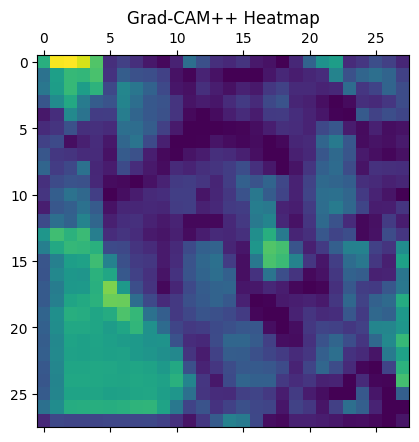

In [39]:
# Generate the Grad-CAM++ heatmap
heatmap1 = grad_cam_plus(
    model1,
    img_array,
    layer_name=last_conv_layer_name,
    label_name=label_name,
    category_id=predicted_class,
)

# Display the heatmap
plt.matshow(heatmap1)
plt.title("Grad-CAM++ Heatmap")
plt.show()

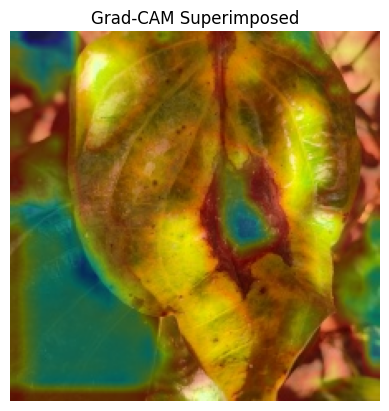

In [40]:
def superimpose_heatmap(heatmap, img_path, alpha=0.5):
    img = load_img(img_path)
    img = img_to_array(img)

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img / np.max(superimposed_img) * 255)
    return superimposed_img

# Generate the superimposed heatmap image
superimposed_img = superimpose_heatmap(heatmap1, img_path)

# Display the superimposed image
plt.imshow(superimposed_img.astype("uint8"))
plt.axis("off")
plt.title("Grad-CAM Superimposed")
plt.show()